0:	learn: 2.8142594	total: 59.3ms	remaining: 1m 28s
1:	learn: 2.0473406	total: 62ms	remaining: 46.4s
2:	learn: 1.8905515	total: 64ms	remaining: 31.9s
3:	learn: 1.8476204	total: 65.6ms	remaining: 24.5s
4:	learn: 1.8171057	total: 67.2ms	remaining: 20.1s
5:	learn: 1.7926522	total: 68.8ms	remaining: 17.1s
6:	learn: 1.7630070	total: 70.2ms	remaining: 15s
7:	learn: 1.7506023	total: 72.1ms	remaining: 13.4s
8:	learn: 1.7378270	total: 73.6ms	remaining: 12.2s
9:	learn: 1.7225493	total: 75.1ms	remaining: 11.2s
10:	learn: 1.7119146	total: 76.8ms	remaining: 10.4s
11:	learn: 1.7022822	total: 78.4ms	remaining: 9.72s
12:	learn: 1.6940495	total: 79.8ms	remaining: 9.13s
13:	learn: 1.6887257	total: 81.3ms	remaining: 8.62s
14:	learn: 1.6841502	total: 82.8ms	remaining: 8.2s
15:	learn: 1.6776803	total: 84.3ms	remaining: 7.82s
16:	learn: 1.6723132	total: 85.7ms	remaining: 7.48s
17:	learn: 1.6636911	total: 87ms	remaining: 7.17s
18:	learn: 1.6589966	total: 88.6ms	remaining: 6.9s
19:	learn: 1.6546661	total: 90m

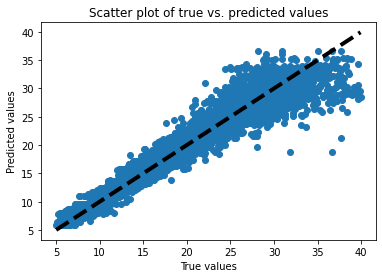

Training set:
R2: 0.95470760506926
NSE: 0.95470760506926
RMSE: 1.2382688396666204
MAE: 0.8164932483704789

Testing set:
R2: 0.9397727420550244
NSE: 0.9397727420550244
RMSE: 1.4229002587557347
MAE: 0.9041896236144253


In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Load and preprocess the dataset
data = pd.read_csv('CanopyTempWeatherGB.csv')

data['CanopyTemp'] = data['CanopyTemp'].astype(float)
data_filtered = data[(data['CanopyTemp'] >= 5) & (data['CanopyTemp'] <= 40)]

X = data_filtered.iloc[:, [6,7]].values

# Perform scaling on the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = data_filtered.iloc[:, 4].values 
y = y.reshape(-1, 1)
y = np.ravel(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define the CatBoost model
model = CatBoostRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [1500],
    'depth': [5],
    'learning_rate': [0.7],
    'loss_function': ['RMSE'],
}

# Perform cross-validation using GridSearchCV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_model = GridSearchCV(model, param_grid, cv=kfold, scoring='neg_mean_squared_error')
cv_model.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", cv_model.best_params_)

# Train the final model with the best hyperparameters
final_model = CatBoostRegressor(**cv_model.best_params_)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

T4SCSM1_CB = pd.DataFrame({'Measured': y_test.flatten(), 'Estimated': y_pred.flatten()})

# Save the DataFrame to a file
T4SCSM1_CB.to_csv('GBSM12_CB.csv', index=False)

plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of true vs. predicted values')

# add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# show the plot
plt.show()

y_train_pred = final_model.predict(X_train)
y_train = y_train.reshape(-1)
y_train_pred = y_train_pred.reshape(-1)
mean_y_train = y_train.mean()
y_train_mean = np.repeat(y_train.mean(), y_train.shape[0])

train_r2 = r2_score(y_train, y_train_pred)
train_nse = 1 - mean_squared_error(y_train, y_train_pred)/mean_squared_error(y_train, y_train_mean)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Training set:")
print("R2:", train_r2)
print("NSE:", train_nse)
print("RMSE:", train_rmse)
print("MAE:", train_mae)
print()

metricstrain = [
    {'Metric': 'RMSE', 'Value': train_rmse},
    {'Metric': 'R2', 'Value': train_r2},
    {'Metric': 'NSE', 'Value': train_nse},
    {'Metric': 'MAE', 'Value': train_mae}
]

df = pd.DataFrame(metricstrain)
df.to_csv('CBSC_trainmetrics.csv', index=False)

y_test_pred = final_model.predict(X_test)
y_test = y_test.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)
mean_y_test = y_test.mean()
y_test_mean = np.repeat(y_test.mean(), y_test.shape[0])

test_r2 = r2_score(y_test, y_test_pred)
test_nse = 1 - mean_squared_error(y_test, y_test_pred)/mean_squared_error(y_test, y_test_mean)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Testing set:")
print("R2:", test_r2)
print("NSE:", test_nse)
print("RMSE:", test_rmse)
print("MAE:", test_mae)

metricstest = [
    {'Metric': 'RMSE', 'Value': test_rmse},
    {'Metric': 'R2', 'Value': test_r2},
    {'Metric': 'NSE', 'Value': test_nse},
    {'Metric': 'MAE', 'Value': test_mae}
]

df = pd.DataFrame(metricstest)
df.to_csv('CBSC_testmetrics.csv', index=False)
